# Pretraining on unlabelled data

## Installation

This notebook uses code from [elcapo/llm-from-scratch](https://github.com/elcapo/llm-from-scratch/). In order to use it:

```bash
git clone https://github.com/elcapo/llm-from-scratch
cd llm-from-scratch

python -m venv .venv
source .venv/bin/activate
pip install -r requirements.txt

jupyter notebook
```

**Have fun!**

## Where were we?

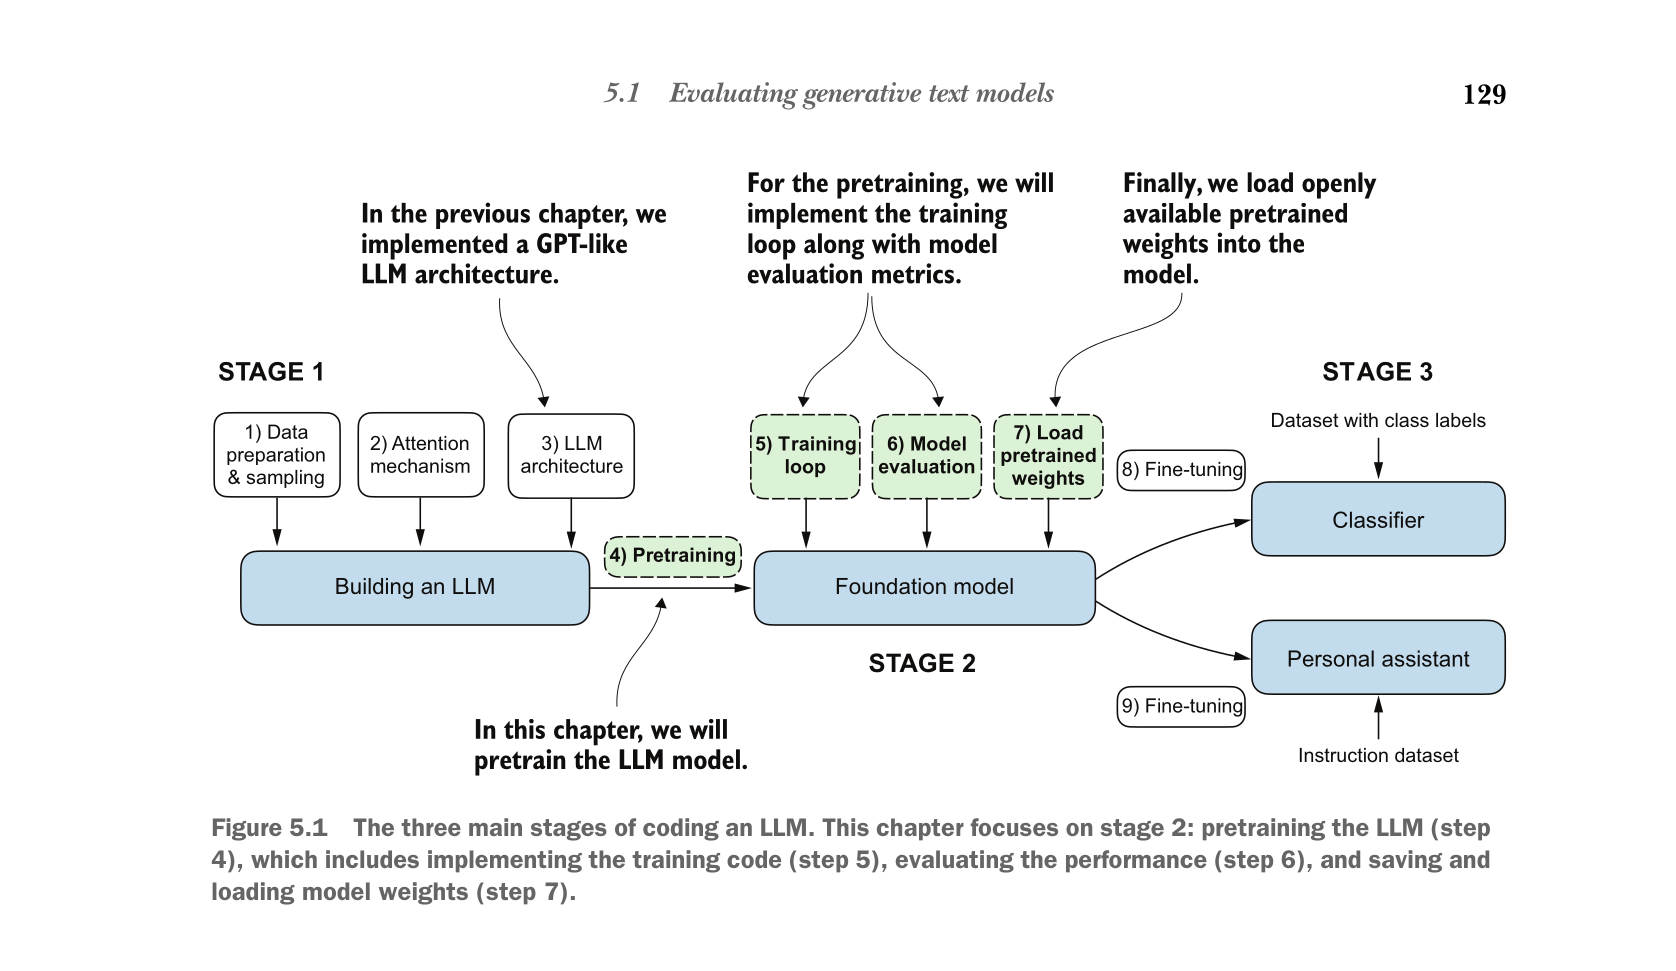

## Where are we going?

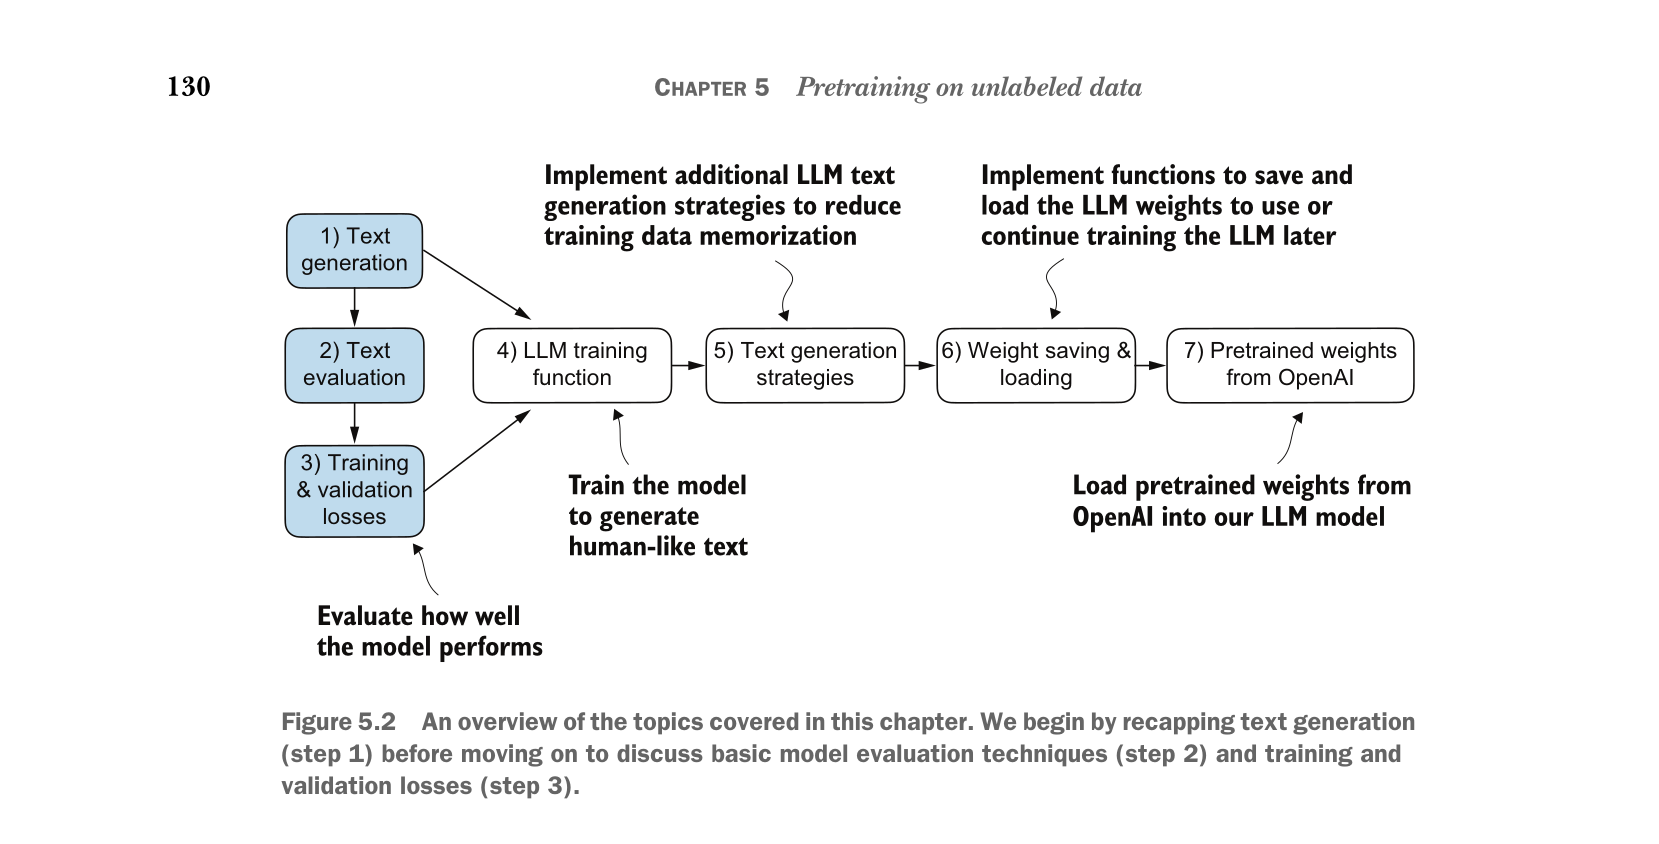

In [1]:
import matplotlib.pyplot as plt
import torch
import warnings

In [2]:
torch.manual_seed(123)
warnings.filterwarnings('ignore')

In [3]:
from scratch.tokenizers.tiktoken_tokenizer import TiktokenTokenizer

tokenizer = TiktokenTokenizer()

inputs = torch.cat(
    (
        tokenizer.text_to_tokens('every effort moves'),
        tokenizer.text_to_tokens('I really like')
    )
)

targets = torch.cat(
    (
        tokenizer.text_to_tokens(' effort moves you'),
        tokenizer.text_to_tokens(' really like chocolate')
    )
)

#### Sources

- [scratch/tokenizers/tiktoken_tokenizer.py](https://github.com/elcapo/llm-from-scratch/blob/main/scratch/tokenizers/tiktoken_tokenizer.py)

In [4]:
from scratch.gpt_config import GptConfig
from scratch.gpt_model import GptModel

config = GptConfig.small()
config.context_length = 256
config.qkv_bias = False

model = GptModel(config)

#### Sources
- [scratch/gpt_config.py](https://github.com/elcapo/llm-from-scratch/blob/main/scratch/gpt_config.py)
- [scratch/gpt_model.py](https://github.com/elcapo/llm-from-scratch/blob/main/scratch/gpt_model.py)

In [5]:
with torch.no_grad():
    logits = model(inputs)

In [6]:
# Why are we doing a softmax, here?
probas = torch.softmax(logits, dim=-1)
token_ids = torch.argmax(probas, dim=-1, keepdim=True)

In [7]:
# We should obtain the same result without the softmax normalization
token_ids = torch.argmax(logits, dim=-1, keepdim=True)

In [8]:
for batch_id, target in enumerate(targets):
    print("")
    print("Batch:", batch_id + 1)
    print("- Input:", tokenizer.tokens_to_text(inputs[batch_id]))
    print("- Target:", tokenizer.tokens_to_text(target))
    print("- Output:", tokenizer.tokens_to_text(token_ids[batch_id].flatten()))


Batch: 1
- Input: every effort moves
- Target:  effort moves you
- Output:  astounding Gad applic

Batch: 2
- Input: I really like
- Target:  really like chocolate
- Output:  diagonal Swords allows


In [9]:
for batch_id, target in enumerate(targets):
    log_probas = torch.log(probas[batch_id, [0, 1, 2], targets[batch_id]])
    print("")
    print("Batch:", batch_id + 1)
    print("- Logits:", logits[batch_id, [0, 1, 2], targets[batch_id]].tolist())
    print("- Probabilities:", probas[batch_id, [0, 1, 2], targets[batch_id]].tolist())


Batch: 1
- Logits: [-0.21120132505893707, 1.3854831457138062, -0.8993706107139587]
- Probabilities: [1.365970638289582e-05, 6.713520997436717e-05, 6.8525569076882675e-06]

Batch: 2
- Logits: [-0.7834552526473999, -0.3723931610584259, -0.6096072793006897]
- Probabilities: [7.715892934356816e-06, 1.1614359209488612e-05, 9.19272133614868e-06]


In [10]:
def plot_probabilities(batch_id):
    fig, ax = plt.subplots()
    
    x = [tokenizer.tokens_to_text(token.unsqueeze(0).unsqueeze(0)) for token in targets[batch_id]]
    y = probas[batch_id, [0, 1, 2], targets[batch_id]].tolist()
    
    ax.bar(x, y, color='green')
    ax.set_title('Probabilities before training for batch ' + str(batch_id + 1))
    fig.show()

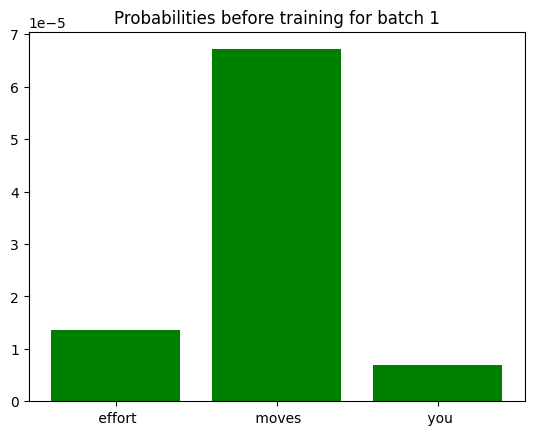

In [11]:
plot_probabilities(batch_id=0)

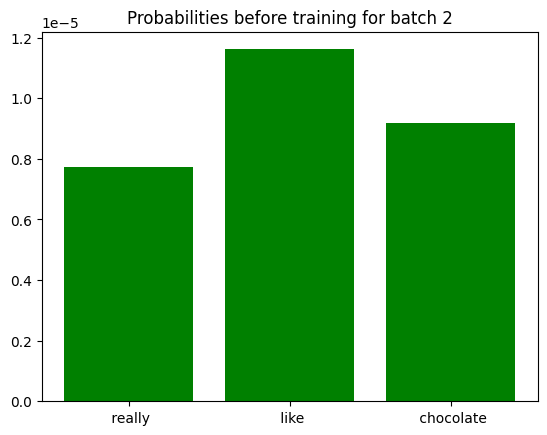

In [12]:
plot_probabilities(batch_id=1)

In [13]:
def plot_contextualized_probabilities(batch_id):
    fig, ax = plt.subplots()
    fig.set_figwidth(9)
    fig.set_figheight(5)
    fig.set_dpi(142)

    batch_words = targets[batch_id]
    other_words = torch.randint(0, config.vocab_size - 1, (6,))

    batch_tokens = [tokenizer.tokens_to_text(token.unsqueeze(0).unsqueeze(0)) for token in batch_words]
    other_tokens = [tokenizer.tokens_to_text(token.unsqueeze(0).unsqueeze(0)) for token in other_words]
    x = batch_tokens + other_tokens
    
    batch_probas = probas[batch_id, [0, 1, 2], batch_words].tolist()
    other_probas = probas[batch_id, 0, other_words].tolist()
    y = batch_probas + other_probas

    batch_color = ['green' for _ in batch_words]
    other_color = ['red' for _ in other_words]
    c = batch_color + other_color
    
    ax.bar(x, y, color=c)
    ax.set_title('Probabilities before training for batch ' + str(batch_id + 1))
    fig.show()

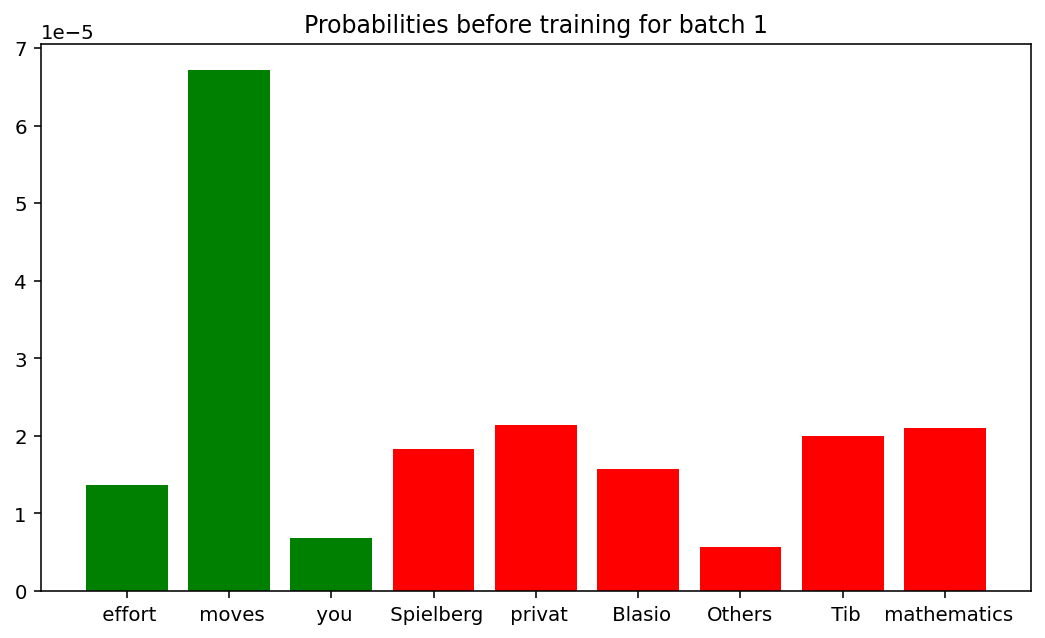

In [14]:
plot_contextualized_probabilities(batch_id=0)

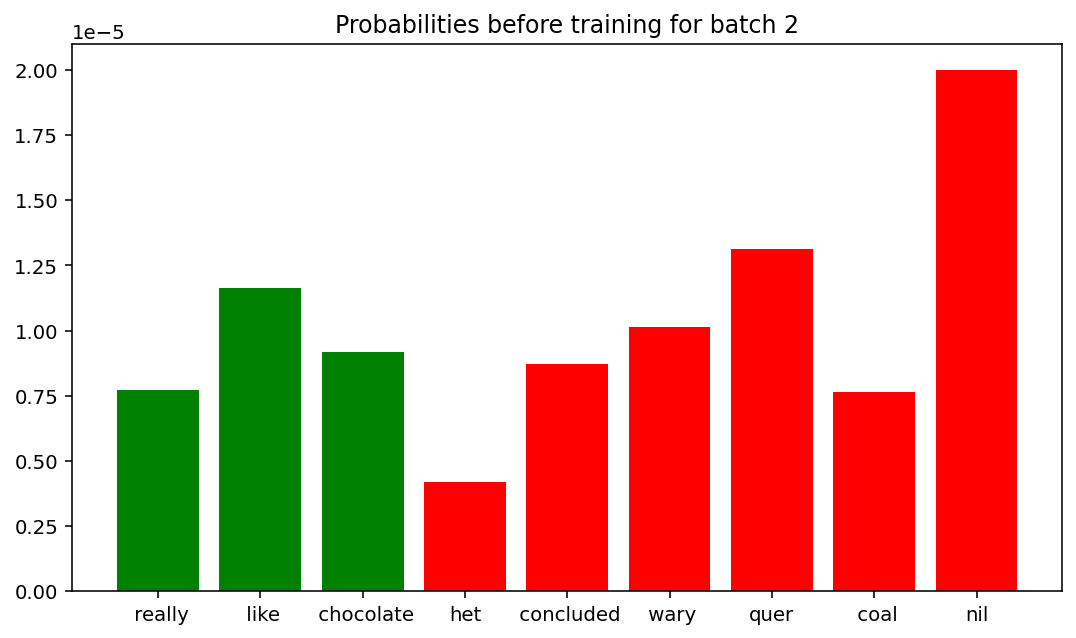

In [15]:
plot_contextualized_probabilities(batch_id=1)

## Text evaluation

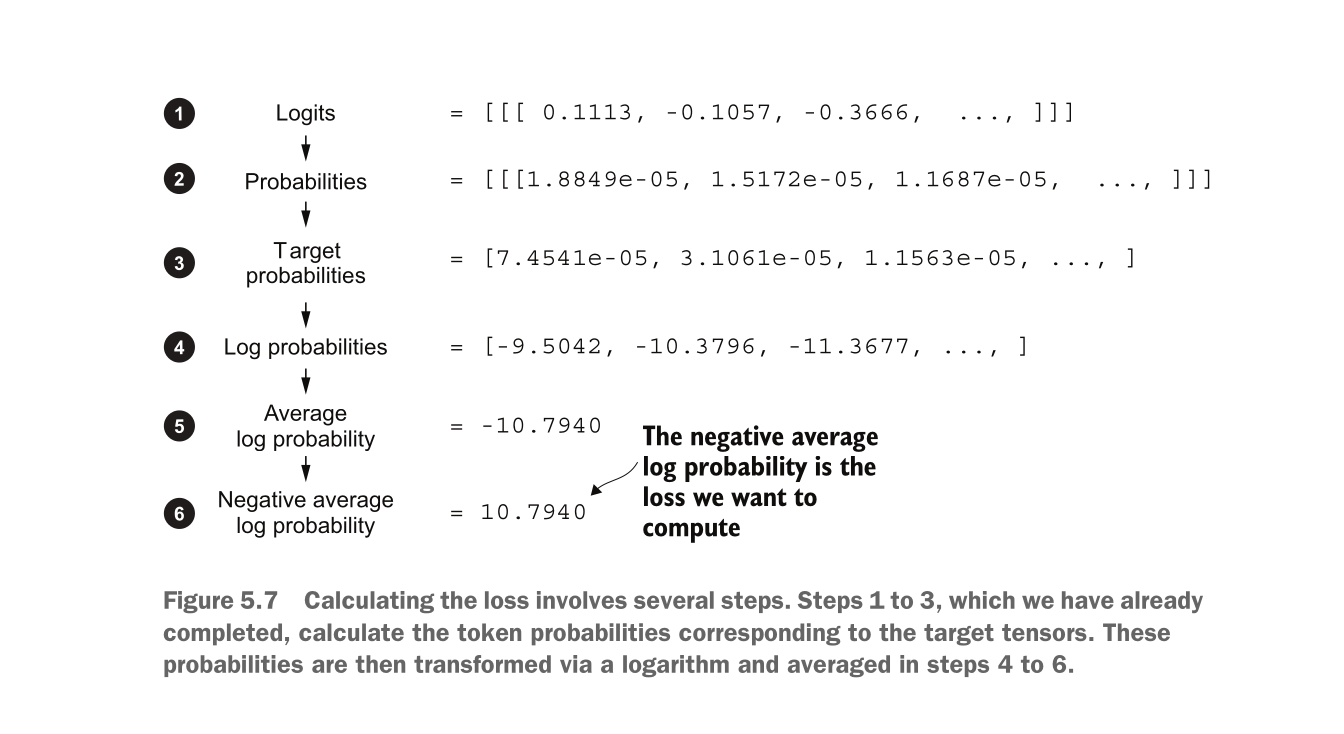

In [16]:
for batch_id, target in enumerate(targets):
    log_probas = torch.log(probas[batch_id, [0, 1, 2], targets[batch_id]])
    print("")
    print("Batch:", batch_id + 1)
    print("- Logits:", logits[batch_id, [0, 1, 2], targets[batch_id]].tolist())
    print("- Probabilities:", probas[batch_id, [0, 1, 2], targets[batch_id]].tolist())
    print("- Logarithm of the probabilities:", log_probas)
    print("- Average of the logarithm", torch.mean(log_probas))
    print("- Negative average of the logarithm", -torch.mean(log_probas))


Batch: 1
- Logits: [-0.21120132505893707, 1.3854831457138062, -0.8993706107139587]
- Probabilities: [1.365970638289582e-05, 6.713520997436717e-05, 6.8525569076882675e-06]
- Logarithm of the probabilities: tensor([-11.2011,  -9.6088, -11.8909])
- Average of the logarithm tensor(-10.9003)
- Negative average of the logarithm tensor(10.9003)

Batch: 2
- Logits: [-0.7834552526473999, -0.3723931610584259, -0.6096072793006897]
- Probabilities: [7.715892934356816e-06, 1.1614359209488612e-05, 9.19272133614868e-06]
- Logarithm of the probabilities: tensor([-11.7722, -11.3633, -11.5971])
- Average of the logarithm tensor(-11.5775)
- Negative average of the logarithm tensor(11.5775)


Sounds good but...
- Why are we taking a logarithm?
- Why are we computing an average?
- Why are we switching the sign?

#### Sources
- [Logistic Regression Loss Function](https://www.youtube.com/watch?v=GxJe0DZvydM) by Sebastian Raschka (2021)

## Calculating the training and validation losses

In [17]:
file_path = "tests/fixtures/the-veredict.txt"
with open(file_path, "r", encoding="utf-8") as f:
    text_data = f.read()

print("Total characters", len(text_data))
print("Total tokens", len(tokenizer.encode(text_data)))

Total characters 20480
Total tokens 5146


In [18]:
train_ratio = 0.9
split_idx = int(train_ratio * len(text_data))

train_data = text_data[:split_idx]
validation_data = text_data[split_idx:]

In [19]:
from scratch.dataloader import create_dataloader

train_loader = create_dataloader(
    train_data,
    batch_size=2,
    max_length=config.context_length,
    stride=config.context_length,
    drop_last=True,
    shuffle=True,
    num_workers=0)

validation_loader = create_dataloader(
    validation_data,
    batch_size=2,
    max_length=config.context_length,
    stride=config.context_length,
    drop_last=False,
    shuffle=False,
    num_workers=0)

In [20]:
print("Train loader")
for x, y in train_loader:
    print("- ", x.shape, y.shape)

print("")
print("Validation loader")
for x, y in validation_loader:
    print("- ", x.shape, y.shape)

Train loader
-  torch.Size([2, 256]) torch.Size([2, 256])
-  torch.Size([2, 256]) torch.Size([2, 256])
-  torch.Size([2, 256]) torch.Size([2, 256])
-  torch.Size([2, 256]) torch.Size([2, 256])
-  torch.Size([2, 256]) torch.Size([2, 256])
-  torch.Size([2, 256]) torch.Size([2, 256])
-  torch.Size([2, 256]) torch.Size([2, 256])
-  torch.Size([2, 256]) torch.Size([2, 256])

Validation loader
-  torch.Size([1, 256]) torch.Size([1, 256])


In [21]:
from scratch.training.loader_loss import LoaderLoss

loader_loss = LoaderLoss(model)

with torch.no_grad():
    train_loss = loader_loss.calc(train_loader)
    validation_loss = loader_loss.calc(validation_loader)

print("Training loss", train_loss)
print("Validation loss", validation_loss)

Training loss 10.998895406723022
Validation loss 10.976768493652344


## Training an LLM

In [22]:
from scratch.training.simple_trainer import SimpleTrainer

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr = 0.0004,
    weight_decay = 0.1)

trainer = SimpleTrainer(
    model,
    train_loader,
    validation_loader,
    optimizer,
    tokenizer)

In [23]:
trainer.train(
    num_epochs = 10,
    eval_freq = 5,
    eval_iter = 5,
    start_context = "Every effort moves you")

Epoch 1
- Step 0
- Train loss 10.017461776733398
- Evaluation loss 10.093018531799316
Epoch 1
- Step 5
- Train loss 8.119176483154297
- Evaluation loss 8.270995140075684
Every effort moves you, the, the, the,, the, the,, the,, the, the,,,,,,, the,, the, the,, the, the,,,, the, the,,,,, the
Epoch 2
- Step 10
- Train loss 6.728001976013184
- Evaluation loss 7.023818016052246
Epoch 2
- Step 15
- Train loss 5.882554912567139
- Evaluation loss 6.52547550201416
Every effort moves you the a a, and, and, and, the, and the.                                   
Epoch 3
- Step 20
- Train loss 14.872119331359864
- Evaluation loss 15.336661338806152
Every effort moves you--I was, and-- a of the-- the a, and. Gisburn, and, and the Gisburn, and, and, and the picture-- the-- was, and, and, and the of the picture, and
Epoch 4
- Step 25
- Train loss 5.179714584350586
- Evaluation loss 6.365568161010742
Epoch 4
- Step 30
- Train loss 5.04006175994873
- Evaluation loss 6.340285778045654
Every effort moves y

([10.017461776733398,
  8.119176483154297,
  6.728001976013184,
  5.882554912567139,
  14.872119331359864,
  5.179714584350586,
  5.04006175994873,
  4.396388816833496,
  3.6562016010284424,
  3.455553388595581,
  2.6653530597686768,
  2.3868751525878906,
  1.8558146715164185,
  1.5611152172088623,
  1.0705187678337098,
  0.9986975312232971],
 [10.093018531799316,
  8.270995140075684,
  7.023818016052246,
  6.52547550201416,
  15.336661338806152,
  6.365568161010742,
  6.340285778045654,
  6.182982444763184,
  6.097899913787842,
  6.107152462005615,
  6.077595233917236,
  6.076347827911377,
  6.09069299697876,
  6.144453525543213,
  6.201166152954102,
  6.231207847595215],
 [512,
  3072,
  5632,
  8192,
  10752,
  13312,
  15872,
  18432,
  20992,
  23552,
  26112,
  28672,
  31232,
  33792,
  36352,
  38912])